# CS352 Machine Learning Coursework

## A: Feature Extraction & Bayes Classifier

### A.1: Extracting, Sampling and Training

**Overview:**

In this section, the CelebA dataset is prepared for use with a Gaussian Naive Bayes classifer. The task invovles three main steps: selecting and sampling images, extracting fixed feature emebeddings using a pre-trained model and finally splitting the data for training.

**Components Used:**

- **Dataset loading and sampling**: Selects 20,000 images from the folder provided and aligns them with their corresponding labels in the CelebA attributes file.
- `ImageDataset` **class**: Custom PyTorch dataset class for loading and preprocessing the images.
- **Preprocessing**: A preprocessing transformation is applied to the images to prepare them for the Vision Transformer.
- `extractFeatures` **function**:  Uses a `create_feature_extractor` to run all sampled images through a pre-trained ViT-B/16 model and produces a 768 dimensional feature vector for each image.
- **Partitioning**: Numpy is used to partition the extracted features into training, calibration and testing sets.

All required libraries for the project are imported here.

In [60]:
import numpy as np
import pandas as pd
import torch
import os
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

The global variables used throughout the project are defined.

In [61]:
# Directory of images to be trained
IMAGE_DIR = "celeba_selection"

# File location of the image attribute file
ATTRIBUTE_FILE = "list_attr_celeba.txt"

# Number of images to be sampled
SAMPLE_SIZE = 20000

# For part C we are only concerned with these image attributes
SELECTED_ATTRIBUTES = ["Smiling", "Male", "Young", "Blond_Hair", "Wearing_Hat"]

# To speed up feature extraction, perform it in batches. If low VRAM, lower this number
BATCH_SIZE = 32

# Attribute for Part A and B
PREDICTION_ATTRIBUTE = "Smiling"

# If you want to re-extract on a new set of images set this to True
RESET = False

# Set to true to enable random partitioning of data
RANDOM = False

# Percentage of images that are part of the training set
TRAINING_PERCENT = 0.7

# Percentage of images that are part of the calibration set
CALIB_PERCENT = 0.15

# The file location of extracted features cache
EMBEDDINGS_FILE = "extracted_features.npz"

This loads a subset of CelebA image filenames from the given directory and retrieves their corresponding attribute labels.

In [62]:
# Load subset of image filenames to be analysed
sampledImageFiles = os.listdir(IMAGE_DIR)[:SAMPLE_SIZE]

# Load attribute file and load selected columns for part C
attributeData = pd.read_csv(
    ATTRIBUTE_FILE,
    sep=r'\s+',
    header=1,
    index_col=0
)[SELECTED_ATTRIBUTES]

# Link each entry in the attribute file to their corresponding image name
sampledAttributes = attributeData.loc[sampledImageFiles]

This below code blocks define a PyTorch dataset class for loading images and a function for extracting Vision Transformer ViT features from those images.

In [63]:
class ImageDataset(Dataset):
    """
    A custom PyTorch Dataset for loading images from a directory.

    Attributes:
        imageNames (list): List of image filenames to load.
        imageDir (str): Path to the directory containing the image files.
        transform (callable, optional): Optional torchvision transform to apply to images.
    """

    def __init__(self, imageNames, imageDir, transform=None):
        """
        Initialise the dataset. 

        Args:
            imageNames (list): List of image filenames to load.
            imageDir (str): Path to the directory containing the image files.
            transform (callable, optional): Optional torchvision transform to apply to images.
        """
        self.imageNames = imageNames
        self.imageDir = imageDir
        self.transform = transform

    def __len__(self):
        """
        Return the number of images in the dataset.

        Returns:
            int: NUmber of image filenames stored.
        """
        return len(self.imageNames)
    
    def __getitem__(self, index):
        """
        Load and return a transformed image at the given index.

        Args:
            index (int): Index of the desired image.

        Returns:
            Tensor: The transformed image tensor.
        """
        if self.transform:
            img = Image.open(os.path.join(self.imageDir, self.imageNames[index])).convert("RGB")
            if self.transform:
                img = self.transform(img)
            return img
        

In [64]:
def extractFeatures(sampledImageFiles, loader, embeddingsFile=EMBEDDINGS_FILE, reset=RESET):
    """
    Extract ViT feature embeddings for a set of images.

    Args:
        sampledImageFiles (list): List of image filenames used in the dataset.
        loader (DataLoader): PyTorch Dataloader for batching image inputs.
        embeddingsFile(str): Path to the .npz file for caching embeddings.
        reset (bool): If True, forces re-extraction even if cached embeddings exist.

    Returns:
        numpy.ndarray: An array of extracted feature vectors.
    """

    # Check for cached embeddings file
    if not reset and os.path.exists(embeddingsFile):

        data = np.load(embeddingsFile)

        savedImageNames = data["imageNames"]

        # If image list in embeddings is not equal to embeddings file then re-extract with new list
        if len(savedImageNames) == len(sampledImageFiles) and  np.array_equal(savedImageNames, sampledImageFiles):
            
            print("Embeddings match sampled image list. Skipping extraction")
            
            return data["embeddings"]
        

    # Load the pretrained ViT model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vit = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1).to(device)
    vit.eval()

    # Create feature extractor to retrieve encoder outputs
    featureExtractor = create_feature_extractor(vit, return_nodes={"encoder": "features"})
    allFeatures = []

    # Extract features with no gradient tracking
    with torch.no_grad():

        with tqdm(total=len(loader.dataset), desc="Extracting ViT Features", colour="#EBBCBA") as pbar:
        
            for batch in loader:
        
                batch = batch.to(device)
                features = featureExtractor(batch)["features"][:, 0] # CLS token
                allFeatures.append(features.cpu())

                # Update progress bar by number of images in the batch
                pbar.update(batch.size(0))

    # Convert list of tensors into one NumPy array
    allFeaturesNP = torch.cat(allFeatures, dim=0).numpy()
    print(f"Feature matrix shape: {allFeaturesNP.shape}")


    np.savez(embeddingsFile, embeddings=allFeaturesNP, imageNames=np.array(sampledImageFiles))
    print(f"Embeddings + image names saved to '{embeddingsFile}'.")

    return allFeaturesNP

Once classes and functions have been defined, the features can be loaded and used for future use in the project.

In [65]:
# Preprocessing: resize, crop, convert to tensor, normalise for ViT
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create dataset with preprocessing
dataset = ImageDataset(sampledImageFiles, IMAGE_DIR, transform=preprocess)

# Create DataLoader for batch processing
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

# Extract ViT embeddings for all images
allFeaturesNP = extractFeatures(sampledImageFiles, loader)

Embeddings match sampled image list. Skipping extraction


Now that features have been extracted and loaded, the target attributes are converted to binary labels between 0 and 1 so they will work within the Gaussian Naive Bayes classifier. Then the dataset is randomly split into the three partitions: training, calibration and testing.

In [66]:
# Convert target attribute from {-1, 1} to {0, 1}
labels = ((sampledAttributes[PREDICTION_ATTRIBUTE].values + 1) // 2).astype(int)

# Compute sizes for training and calibration sets
trainSize = int(TRAINING_PERCENT * SAMPLE_SIZE)
calibSize = int(CALIB_PERCENT * SAMPLE_SIZE)

# Create array of indices for all samples
indices = np.arange(SAMPLE_SIZE)

# Shuffle indices if RANDOM is True
if RANDOM:
    np.random.shuffle(indices)

# Split indices into the three partitions
trainIndex, calibIndex, testIndex = np.split(indices, [trainSize, trainSize + calibSize])

# Select feature embeddings and labels for each set
XTrain, yTrain = allFeaturesNP[trainIndex], labels[trainIndex]
XCalib, yCalib = allFeaturesNP[calibIndex], labels[calibIndex]
XTest, yTest = allFeaturesNP[testIndex], labels[testIndex]

### A.2 Training the Gaussian Naive Bayes Classifier

**Overview:**

In this section, a Gaussian Naive Bayes Classifier is trained using the feature embeddings extracted from the CelebA dataset. The model is then used to predict the "Smiling" attribute which the accuracy is then measured to determine the effectiveness of the GNB model.

**Components Used:**

- `GaussianNaiveBayes` **class**: Implements a GNB classifier with methods to train on data, compute log-probabilities and predict class labels.
- `train` **method**: Calculates class-specific means, variances and prior probabilities from the training features and labels using the following formulas:
  - **Mean:**  
  $$
  \mu_{c,i} = \frac{1}{N_c} \sum_{j=1}^{N_c} X_{j,i} \quad \text{for samples } X_j \text{ in class } c
  $$

  - **Variance:**  
  $$
  \sigma_{c,i}^2 = \frac{1}{N_c} \sum_{j=1}^{N_c} (X_{j,i} - \mu_{c,i})^2 + \epsilon
  $$
  where $\epsilon$ is a small constant added for numerical stability, in this case its $10^{-6}$

  - **Prior probability:**  
  $$
  P(c) = \frac{N_c}{N}
  $$

- `predictProbabilities` **method**: Computes the log-posterior for each class using the Gaussian probability density function:

  - **Log-likelihood for a feature vector \(X\):**  
  $$
  \log P(X|c) = \sum_{i=1}^{d} \log \frac{1}{\sqrt{2 \pi \sigma_{c,i}^2}} \exp\Big(-\frac{(X_i - \mu_{c,i})^2}{2 \sigma_{c,i}^2}\Big)
  $$

  - **Log-posterior:**  
  $$
  \log P(c|X) \propto \log P(X|c) + \log P(c)
  $$

  - **Class probabilities (softmax):**  
  $$
  P(c|X) = \frac{\exp(\log P(c|X))}{\sum_{c'} \exp(\log P(c'|X))}
  $$

- `predict` **method**: Predicts the class with the highest posterior probability:

$$
\hat{y} = \arg\max_c P(c|X)
$$

- **Training and evaluation**: The model is trained on `XTrain` and `yTrain`, then tested on `XTest` to obtain predictions and compute test accuracy:

$$
\text{Accuracy} = \frac{\text{\# correct predictions}}{\text{total test samples}}
$$

The Gaussian Naive Bayes (GNB) class is defined here.

In [67]:
class GaussianNaiveBayes:
    """
    GNB Classifier for multi-class data.

    Assumes conditional independence and that each feature follows a Gaussian (Normal) distribution.

    Attributes:
        classes (ndarray): Unique class labels.
        means (ndarray): Mean of each feature for each class.
        variances (ndarray): Variance of each feature for the class.
        priors (ndarray): Prior probabilities for each class.
    """

    def __init__(self):
        """
        Initalise the classifier, model parameters set to None.
        """

        self.classes = None
        self.means = None
        self.variances = None
        self.priors = None


    def train(self, X, y):
        """
        Train the Gaussian Naive Bayes classifier.

        Args:
            X (ndarray): Feature matrix of shape (numSamples, numFeatures).
            y (ndarray): Target labels of shape (numSamples,).
        
        Computes:
            - Class-specific means and variances for each feature.
            - Prior probabilities for each class.
        """

        # Identify all unique classes in the training data
        self.classes = np.unique(y)
        numFeatures = X.shape[1]

        # Initialise arrays to hold means, variances and priors
        self.means = np.zeros((len(self.classes), numFeatures))
        self.variances = np.zeros((len(self.classes), numFeatures))
        self.priors = np.zeros(len(self.classes))

        # Compute statistics for each class
        for index, c in enumerate(self.classes):
            
            # Select all samples belonging to class c
            Xc = X[y == c]

            # Compute mean and variance for each feature in this class
            self.means[index] = Xc.mean(axis=0)
            self.variances[index] = Xc.var(axis=0) + 1e-6

            # Compute prior probability of the class
            self.priors[index] = len(Xc) / len(X)

    
    def __log_gaussian_pdf(self, X, mean, variance):
        """
        Compute the log of the Gaussian Probability Density Function.

        Args:
            X (ndarray): Feature values.
            mean (ndarray): Mean values for each feature.
            variance (ndarray): Variances for each feature

        Returns:
            ndarray: Log-probability of X under a Gaussian distribution
        """
        return -0.5 * (np.log(2 * np.pi * variance) + ((X - mean) ** 2) / variance)

    def predict(self, X):
        """
        Predict class labels for input data.

        Args:
            X (ndarray): Feature matrix of shape (numSamples, numFeatures).

        Returns:
            ndarray: Predicted class labels.
        """

        # Compute class probabilities and select the class with maximum probability
        probs = self.predictProbabilities(X)
        return self.classes[np.argmax(probs, axis=1)]

        
    def predictProbabilities(self, X):
        """
        Compute class probabilitites for input data.

        Args:
            X (ndarray): Feature matrix of shape (numSamples, numFeatures).

        Returns:
            ndarray: Probability of each class for each sample.
        """

        logPosteriors = []

        # Compute log-posterior for each class
        for index in range(len(self.classes)):
            mean = self.means[index]
            variance = self.variances[index]
            logPrior = np.log(self.priors[index])

            # Compute log-liklihood for all features and sum over features
            logLikelihood = np.sum(self.__log_gaussian_pdf(X, mean, variance), axis=1)

            # Log-posterior - log-liklihood + log-prior
            logPosteriors.append(logLikelihood + logPrior)

        # Stack log-posteriors for all classes (shape: numSamples x numClasses)
        logPosteriors = np.vstack(logPosteriors).T

        # Apply softmax to convert log-posteriors to probabilities
        maxLog = np.max(logPosteriors, axis=1, keepdims=True)
        expScores = np.exp(logPosteriors - maxLog)
        probabilities = expScores / np.sum(expScores, axis=1, keepdims=True)

        return probabilities


Now that the class has been defined we can use it to see how effective the naiive bayes classifier is for this dataset

In [68]:
gnb = GaussianNaiveBayes()
gnb.train(XTrain, yTrain)
yPred = gnb.predict(XTest)
accuracy = np.mean(yPred == yTest)
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.6906666666666667


## B: Population Calibration

### B.1 Computing predicted probabilitites

**Overview**:

In this section, the calibration of the GNB classifier is evaluated. Using the calibration set, we compute predicted probabiltities for the target class (*Smiling Faces*) and visualise how well these predicted probabilities correspond to actual outcomes using a reliability diagram.

**Components Used**:

- `predictProbabilities` **method**: Computes the predicted probability of each class for every sample in the calibration set (defined above).
- `plotReliabilityDiagram` **function**:
    - Divides predicted probabilities into bins (e.g., 10 bins from 0 to 1).
    - Computes the mean predicted probability and the actual fraction of positive samples within each bin.
    - Plots predicted probability vs. actual fraction, with a reference line showing perfect calibration.

A function is now defined that allows us to plot reliability diagram

In [76]:
def plotReliabilityDiagram(yTrue, yProb, numBins=10):
    """
    Plot a relibaility diagram to evalute classifier calibration.

    Args:
        yTrue (ndarray): True binary labels (0 or 1)
        yProb (ndarray): Predicted probabilities for the positive class
        numBins (int): Number of bins to group predicted probabilities
    """
    
    # Create equally spaced bin edges from 0 to 1
    binEdges = np.linspace(0, 1, numBins + 1)
    binIndices = np.digitize(yProb, binEdges) - 1

    # Compute mean confidence and accuracy per bin using vectorised operations
    accuracies = np.zeros(numBins)
    confidences = np.zeros(numBins)
    counts = np.zeros(numBins)

    # Loop over each bin
    for i in range(numBins):

        # Identify predictions that fall within the current bin
        inBin = (binIndices == i)
        counts[i] = np.sum(inBin)

        if counts[i] > 0:

            # Compute mean true label (accuracy) and mean predicted probability (confidence)
            accuracies[i] = np.mean(yTrue[inBin])
            confidences[i] = np.mean(yProb[inBin])
        
        else:

            # No samples in this bin, store Not a Number (NaN)
            accuracies[i] = np.nan
            confidences[i] = np.nan
        
    
    # Plot the reliability diagram
    plt.figure(figsize=(6,6))
    plt.plot([0,1],[0,1], 'k--', label="Perfect Calibration")
    plt.plot(confidences, accuracies, marker="o", linestyle="None")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Actual Probability")
    plt.title("Reliability Diagram")
    plt.show()

The probabilities are calculated for *Smiling Faces* using the calibration set and reliability diagram is plotted.

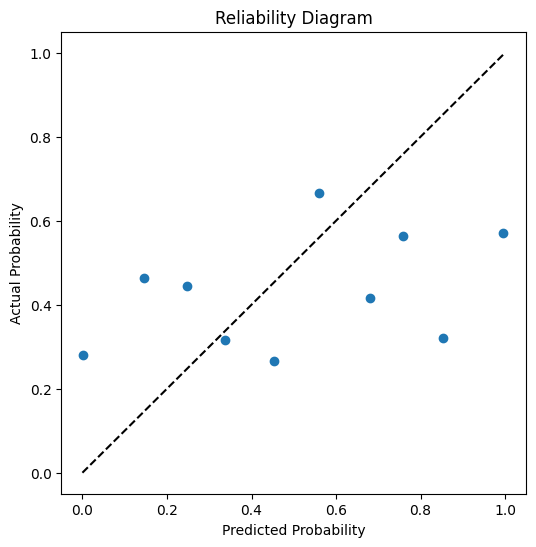

In [75]:
pCalib = gnb.predictProbabilities(XCalib)[:, 1]
plotReliabilityDiagram(yCalib, pCalib)

### B.2 Computing ECE 

**Overview**:

Here, the calibration of GNB is evaluated using the Expected Calibration Error (ECE) and Mean Squared Error (MSE) between practical probabilities and true outcomes to determine whether the model tends to be overconfident or underconfident.

**Components Used**:

- `computeECE` **function**: Calculates the ECE using binned probabilities.
- `computeMSE` **function**: Computes the mean squared error between predictions and true labels.
- `predictProbabilities` **method**: Used on calibration instnace of GNB to create the data used in the calculations.

We have to create the 2 functions that compute ECE and MSE.

In [ ]:
def computeECE(yTrue, yProb, numBins=10):
    """
    Compute Expected Calibration Error for probabilistic predictions.

    Args:
        yTrue (ndarray): True binary labels (0 or 1).
        yProb (ndarray): Predicted probabilities for the positive class.
        numBins (int): Number of bins to group predicted probabilities.

    Returns:
        float: ECE score
    """
    # Crate bin edges and assign predictions to bins
    binEdges = np.linspace(0, 1, numBins + 1) 
    binIndices = np.digitize(yProb, binEdges) - 1
    
    # Clip indices to ensure they are within [0, numBins-1]
    binIndices = np.clip(binIndices, 0, numBins - 1)

    # Initialise arrays for bin counts, mean accuracies and confidences
    counts = np.bincount(binIndices, minlength=numBins)

    # Avoid division by 0 by masking empty bins later
    binSumsTrue = np.bincount(binIndices, weights=yTrue, minlength=numBins)
    binSumsProb = np.bincount(binIndices, weights=yProb, minlength=numBins)

    # Compute mean accuracy and mean confidence per bin
    mask = counts > 0
    accuracies = np.zeros(numBins)
    confidences = np.zeros(numBins)
    accuracies[mask] = binSumsTrue[mask] / counts[mask]
    confidences[mask] = binSumsProb[mask] / counts[mask]

    # Compute ECE: weighted average of | accuracy - confidence |
    ece = np.sum((counts[mask] / len(yTrue)) * np.abs(accuracies[mask] - confidences[mask]))

    return ece



def computeMSE(yTrue, yProb):
    """
    Compute Mean Squared Error (MSE).

    Args:
        yTrue (ndarray): True binary labels (0 or 1)
        yProb (ndarray): Predicted probabilities for the positive class

    Returns:
        float: MSE score
    """
    return np.mean((yTrue - yProb) ** 2)


As the functions have now been generated we can compute the values based on the test data set.

In [89]:
pTest = gnb.predictProbabilities(XTest)[:, 1]
ece = computeECE(yTest, pTest)
mse = computeMSE(yTest, pTest)

print(f"ECE: {ece}\nMSE: {mse}")

ECE: 0.2955011696477864
MSE: 0.29895156913038357


# Part C - Subgroup Calibration

## 1. Plotting reliability, computing ECE, MSE for each subgroup & summary table

First task is to define the subgroups in a format that we can use easily

In [73]:
# Since the feature set doesnt have features such as female, we assign female as when male is false

SUBGROUPS = {
    "Male": sampledAttributes["Male"] == 1,
    "Female": sampledAttributes["Male"] == 0,
    "Young": sampledAttributes["Young"] == 1,
    "Not Young": sampledAttributes["Young"] == 0,
    "Blond_Hair": sampledAttributes["Blond_Hair"] == 1,
    "Not Blond_Hair": sampledAttributes["Blond_Hair"] == 0,
    "Wearing_Hat": sampledAttributes["Wearing_Hat"] == 1,
    "Not Wearing_Hat": sampledAttributes["Wearing_Hat"] == 0
}